In [1]:
require 'cudnn'
require 'inn'
require 'image'
require 'dcnn'

-- Loads the mapping from net outputs to human readable labels
function load_synset()
  local file = io.open 'synset_words.txt'
  local list = {}
  while true do
    local line = file:read()
    if not line then break end
    table.insert(list, string.sub(line,11))
  end
  return list
end

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 
print '==> Loading network'

--net = torch.load('/home/yusheng/Workspace/DeepLearning/models/zeilerNet/zeilerNet.net')
net = torch.load('/usr/local/data/zeilerNet/zeilerNet.net')
net:cuda()
-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading synsets'
synset_words = load_synset()

print '==> Loading image and imagenet mean'
--image_name = 'Goldfish3.jpg'
--image_name = 'lena.jpg'
image_name='people.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)


-- Replace pooling by dual pooling
unpooling_layers = dcnn:ReplaceDualPoolingModule(net:get(1))

_,classes = net:forward(I:cuda()):view(-1):float():sort(true)

for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i] ])
end

==> Loading network	


==> Loading synsets	
==> Loading image and imagenet mean	


==> Preprocessing	


predicted class 1: 	restaurant, eating house, eating place, eatery	
predicted class 2: 	groom, bridegroom	
predicted class 3: 	bow tie, bow-tie, bowtie	
predicted class 4: 	candle, taper, wax light	
predicted class 5: 	ocarina, sweet potato	


==> Time elapsed: 0.22973799705505 seconds	


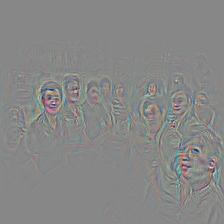

In [20]:
-- set deconvNet
deconvNet = nn.Sequential()

conv5_fm = net:get(1):get(13).output
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(13), net:get(1):get(11).output:size(2), 27 ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(11), net:get(1):get(9).output:size(2), true ))
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(9), net:get(1):get(8).output:size(2), true ))
deconvNet:add(unpooling_layers[2])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(5), net:get(1):get(4).output:size(2), true ))
deconvNet:add(unpooling_layers[1])
deconvNet:add(cudnn.ReLU(true))
deconvNet:add(cudnn.SpatialDeconvolution( net:get(1):get(1), I:size(2), true ))




deconv_timer = torch.Timer()
vis_c5 = deconvNet:forward(conv5_fm)

print('==> Time elapsed: ' .. deconv_timer:time().real .. ' seconds')
itorch.image(vis_c5)

--print(unpooling_layers)

In [13]:
net

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> output]
  (1): nn.Sequential {
    [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> output]
    (1): cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)
    (2): cudnn.ReLU
    (3): inn.SpatialSameResponseNormalization
    (4): dcnn.DualSpatialMaxPooling(3,3,2,2)
    (5): cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)
    (6): cudnn.ReLU
    (7): inn.SpatialSameResponseNormalization
    (8): dcnn.DualSpatialMaxPooling(3,3,2,2)
    (9): cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)
    (10): cudnn.ReLU
    (11): cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)
    (12): cudnn.ReLU
    (13): cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)
    (14): cudnn.ReLU
  }
  (2): inn.SpatialPyramidPooling
  (3): nn.Sequential {
    [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> output]
    (1): nn.Linear(12800 -> 4096)
    (2): cudnn.ReLU
    (3): nn.Dropout(0.50000

            cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)
                {
                  padW : 1
                  nInputPlane : 3
                  output : CudaTensor - size: 96x110x110
                  gradInput : CudaTensor - size: 3x224x224
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40089ad0
                  iSize : LongStorage - size: 4
                  convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x40c2bc60
                  output_offset : 1161600
                  gradBias : CudaTensor - size: 96
                  algType : cdata<enum 761 [?]>: 0x41013f70
                  extraBuffer : CudaTensor - size: 147
                  extraBufferSizeInBytes : 588
                  oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x40ce9168
                  oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x4043b530
                  groups : 1
                  dH : 2
                  dW : 2
     

             nOutputPlane : 96
                  bias : CudaTensor - size: 96
                  kH : 7
                  weight_offset : 14112
                  finput : CudaTensor - empty
                  biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x4081d0d0
                  input_offset : 150528
                  weight : CudaTensor - size: 96x3x7x7
                  train : false
                  gradWeight : CudaTensor - size: 96x3x7x7
                  fgradInput : CudaTensor - empty
                  kW : 7
                  padH : 1
                  weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x412a5ed0
                }
              2 : 
                cudnn.ReLU
                {
                  inplace : true
                  mode : CUDNN_ACTIVATION_RELU
                  train : false


                  output : CudaTensor - size: 96x110x110
                  gradInput : CudaTensor - empty
                  nElem : 1161600
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41024788
                }
              3 : 
                inn.SpatialSameResponseNormalization
                {
                  alpha : 5e-05
                  train : false
                  output : CudaTensor - size: 96x110x110
                  gradInput : CudaTensor - empty
                  size : 3
                  beta : 0.75
                  modules : nn.Sequential {
  [input -> (1) -> (2) -> output]
  (1): nn.ConcatTable {
    input
      |`-> (1): nn.Identity
      |`-> (2): nn.Sequential {
      |      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> output]
      |      (1): nn.SpatialZeroPadding(l=1,r=1,t=1,b=1)
      |      (2): nn.Power
      |      (3): nn.SpatialAveragePooling(3,3,1,1)
      |      (4): nn.MulConstant
      |      (5): nn.AddConstant
  

           4 : 
                dcnn.DualSpatialMaxPooling(3,3,2,2)
                {
                  dH : 2
                  dW : 2
                  padH : 0
                  gradInput : CudaTensor - empty
                  indices : CudaTensor - size: 96x55x55
                  dualModule : dcnn.DualSpatialMaxUnpooling
                  kH : 3
                  output : CudaTensor - size: 96x55x55
                  padW : 0
                  kW : 3
                }
              5 : 
                cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)
                {
                  padW : 0
                  nInputPlane : 96
                  output : CudaTensor - size: 256x26x26
          

        gradInput : CudaTensor - size: 96x55x55
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40ce8058
                  iSize : LongStorage - size: 4
                  convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x412b3d70
                  output_offset : 173056
                  gradBias : CudaTensor - size: 256
                  algType : cdata<enum 761 [?]>: 0x4009f3e8
                  extraBuffer : CudaTensor - size: 2400
                  extraBufferSizeInBytes : 9600
                  oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x40ccd9e8
                  oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40cd5860
                  groups : 1
                  dH : 2
                  dW : 2
                  nOutputPlane : 256
                  bias : CudaTensor - size: 256
                  kH : 5
                  weight_offset : 614400
                  finput : CudaTensor - empty
      

            biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x4059dad0
                  input_offset : 290400
                  weight : CudaTensor - size: 256x96x5x5
                  train : false
                  gradWeight : CudaTensor - size: 256x96x5x5
                  fgradInput : CudaTensor - empty
                  kW : 5
                  padH : 0
                  weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x4081f1c0
                }
              6 : 
                cudnn.ReLU
                {
                  inplace : true
                  mode : CUDNN_ACTIVATION_RELU
                  train : false
                  output : CudaTensor - size: 256x26x26
                  gradInput : CudaTensor - empty
                  nElem : 173056
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41b87eb8
            

    }
              7 : 
                inn.SpatialSameResponseNormalization
                {
                  alpha : 5e-05
                  train : false
                  output : CudaTensor - size: 256x26x26
                  gradInput : CudaTensor - empty
                  size : 3
                  beta : 0.75
                  modules : nn.Sequential {
  [input -> (1) -> (2) -> output]
  (1): nn.ConcatTable {
    input
      |`-> (1): nn.Identity
      |`-> (2): nn.Sequential {
      |      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> output]
      |      (1): nn.SpatialZeroPadding(l=1,r=1,t=1,b=1)
      |      (2): nn.Power
      |      (3): nn.SpatialAveragePooling(3,3,1,1)
      |      (4): nn.MulConstant
      |      (5): nn.AddConstant
      |      (6): nn.Power
      |    }
       ... -> output
  }
  (2): nn.CDivTable
}
                }
              8 : 
                dcnn.DualSpatialMaxPooling(3,3,2,2)
                {
                  dH : 2
            

           kH : 3
                  output : CudaTensor - size: 256x13x13
                  padW : 0
                  kW : 3
                }
              9 : 
                cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)
                {
                  padW : 1
                  nInputPlane : 256
                  output : CudaTensor - size: 384x13x13
                  gradInput : CudaTensor - size: 256x13x13
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40ce6b50
                  iSize : LongStorage - size: 4
                  convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x4098e828
                  output_offset : 64896
                  gradBias : CudaTensor - size: 384
                  algType : cdata<enum 761 [?]>: 0x401e2b48
                  extraBuffer : CudaTensor - size: 2304
                  extraBufferSizeInBytes : 9216
                  oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x412bccb0
  

                oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x419905f0
                  groups : 1
                  dH : 1
                  dW : 1
                  nOutputPlane : 384
                  bias : CudaTensor - size: 384
                  kH : 3
                  weight_offset : 884736
                  finput : CudaTensor - empty
                  biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x406e1bd0
                  input_offset : 43264
                  weight : CudaTensor - size: 384x256x3x3
                  train : false
                  gradWeight : CudaTensor - size: 384x256x3x3
                  fgradInput : CudaTensor - empty
                  kW : 3
                  padH : 1
                  weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x406dbde0
                }
              10 : 
                cudnn.ReLU
                {


                  inplace : true
                  mode : CUDNN_ACTIVATION_RELU
                  train : false
                  output : CudaTensor - size: 384x13x13
                  gradInput : CudaTensor - empty
                  nElem : 64896
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x401d4b38
                }
              11 : 
                cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)
                {
                  padW : 1
                  nInputPlane : 384
                  output : CudaTensor - size: 384x13x13
                  gradInput : CudaTensor - size: 384x13x13
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x417d1890
                  iSize : LongStorage - size: 4
                  convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x4042e408
                  output_offset : 64896
                  gradBias : CudaTensor - size: 384
                  

algType : cdata<enum 761 [?]>: 0x40c570f0
                  extraBuffer : CudaTensor - size: 3456
                  extraBufferSizeInBytes : 13824
                  oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x409ee8f8
                  oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40c61170
                  groups : 1
                  dH : 1
                  dW : 1
                  nOutputPlane : 384
                  bias : CudaTensor - size: 384
                  kH : 3
                  weight_offset : 1327104
                  finput : CudaTensor - empty
                  biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x4043a270
                  input_offset : 64896
                  weight : CudaTensor - size: 384x384x3x3
                  train : false
                  gradWeight : CudaTensor - size: 384x384x3x3
                  fgradInput : CudaTensor - empty
                  kW : 3
                  padH : 1
                  weightDesc : cdata<struct cudn

          }
              12 : 
                cudnn.ReLU
                {
                  inplace : true
                  mode : CUDNN_ACTIVATION_RELU
                  train : false
                  output : CudaTensor - size: 384x13x13
                  gradInput : CudaTensor - empty
                  nElem : 64896
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40cf4398
                }
              13 : 
                cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)
                {
                  padW : 1
                  nInputPlane : 384
                  output : CudaTensor - size: 256x13x13
                  gradInput : CudaTensor - size: 384x13x13
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40427e48
                  iSize : LongStorage - size: 4
                  convDesc : cdata<struct cudnnConvolutionStruct *[1]>: 0x40599630
                  output_offset : 43264


                  gradBias : CudaTensor - size: 256
                  algType : cdata<enum 761 [?]>: 0x417d3b10
                  extraBuffer : CudaTensor - size: 3456
                  extraBufferSizeInBytes : 13824
                  oDescForBias : cdata<struct cudnnTensorStruct *[1]>: 0x40817ea8
                  oDesc : cdata<struct cudnnTensorStruct *[1]>: 0x408248f8
                  groups : 1
                  dH : 1
                  dW : 1
                  nOutputPlane : 256
                  bias : CudaTensor - size: 256
                  kH : 3
                  weight_offset : 884736
                  finput : CudaTensor - empty
                  biasDesc : cdata<struct cudnnTensorStruct *[1]>: 0x406ad060
                  input_offset : 64896
                  weight : CudaTensor - size: 256x384x3x3
                  train : false
                  gradWeight : CudaTensor - size: 256x384x3x3
                  fgradInput : CudaTensor - empty
                  

kW : 3
                  padH : 1
                  weightDesc : cdata<struct cudnnFilterStruct *[1]>: 0x406c0d00
                }
              14 : 
                cudnn.ReLU
                {
                  inplace : true
                  mode : CUDNN_ACTIVATION_RELU
                  train : false
                  output : CudaTensor - size: 256x13x13
                  gradInput : CudaTensor - empty
                  nElem : 43264
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x4081e0e8
                }
            }
          train : false
          output : CudaTensor - size: 256x13x13
        }
      2 : 
        inn.SpatialPyramidPooling
        {
          pyr : 
            {
              1 : 
                {
                  1 : 1
                  2 : 1
          

      }
              2 : 
                {
                  1 : 2
                  2 : 2
                }
              3 : 
                {
                  1 : 3
                  2 : 3
                }
              4 : 
                {
                  1 : 6
                  2 : 6
                }
            }
          train : false
          output : CudaTensor - size: 12800
          gradInput : CudaTensor - empty
          module : 
            nn.Concat {
              input
                |`-> (1): nn.Sequential {
                |      [input -> (1) -> (2) -> output]
                |      (1): nn.SpatialAdaptiveMaxPooling
                |      (2): nn.View
                |    }
                |`-> (2): nn.Sequential {
                |      [input -> (1) -> (2) -> output]
                |      (1): nn.SpatialAdaptiveMaxPooling
                |      (2): nn.View
                |    }
                |`-> (3): nn.Sequential {
                |      [inpu

              output : CudaTensor - size: 12800
              gradInput : CudaTensor - empty
              modules : 
                {
                  1 : nn.Sequential {
  [input -> (1) -> (2) -> output]
  (1): nn.SpatialAdaptiveMaxPooling
  (2): nn.View
}
                  2 : nn.Sequential {
  [input -> (1) -> (2) -> output]
  (1): nn.SpatialAdaptiveMaxPooling
  (2): nn.View
}
                  3 : nn.Sequential {
  [input -> (1) -> (2) -> output]
  (1): nn.SpatialAdaptiveMaxPooling
  (2): nn.View
}
                  4 : nn.Sequential {
  [input -> (1) -> (2) -> output]
  (1): nn.SpatialAdaptiveMaxPooling
  (2): nn.View
}
                }
              size : LongStorage - size: 1
              dimension : 1
            }
          dimd : 1
        }
      3 : 
        nn.Sequential {
          [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> output]
          (1): nn.Linear(12800 -> 4096)
          (2): cudnn.ReLU
          (3): nn.Dropout(0.500000)
          (4): nn.

            bias : CudaTensor - size: 4096
                  gradInput : CudaTensor - empty
                  output : CudaTensor - size: 4096
                  gradWeight : CudaTensor - size: 4096x12800
                }
              2 : 
                cudnn.ReLU
                {
                  inplace : true
                  mode : CUDNN_ACTIVATION_RELU
                  train : false
                  output : CudaTensor - size: 4096
                  gradInput : CudaTensor - empty
                  nElem : 4096
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x4042c738
                }
              3 : 
                nn.Dropout(0.500000)
                {
                  v2 : false
                  noise : CudaTensor - empty
                  train : false


                  p : 0.5
                  gradInput : CudaTensor - empty
                  output : CudaTensor - size: 4096
                }
              4 : 
                nn.Linear(4096 -> 4096)
                {
                  gradBias : CudaTensor - size: 4096
                  weight : CudaTensor - size: 4096x4096
                  train : false


                  bias : CudaTensor - size: 4096
                  gradInput : CudaTensor - empty
                  output : CudaTensor - size: 4096
                  gradWeight : CudaTensor - size: 4096x4096
                }
              5 : 
                cudnn.ReLU
                {
                  inplace : true
                  mode : CUDNN_ACTIVATION_RELU
                  train : false
                  output : CudaTensor - size: 4096
                  gradInput : CudaTensor - empty
                  nElem : 4096
                  iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40091440
                }
              6 : 
                nn.Dropout(0.500000)
                {
                  v2 : false
                  noise : CudaTensor - empty


                  train : false
                  p : 0.5
                  gradInput : CudaTensor - empty
                  output : CudaTensor - size: 4096
                }
              7 : 
                nn.Linear(4096 -> 1000)
                {
                  gradBias : CudaTensor - size: 1000
                  weight : CudaTensor - size: 1000x4096
                  train : false
                  bias : CudaTensor - size: 1000
                  gradInput : CudaTensor - empty
                  output : CudaTensor - size: 1000
                  gradWeight : CudaTensor - size: 1000x4096
                }
            }
          train : false
          output : CudaTensor - size: 1000
        }
    }
  train : false
  output : CudaTensor - size: 1000
}


In [51]:
function dcnn:CreateDeconvNet( net, unpooling_layers, input_img, layer_num, neuron_index, normal_deconv  )
    neuron_index = neuron_index or 0
    if neuron_index == true then
        neuron_index = 0 
        normal_deconv = true
    end
    
    if neuron_index == false then
        neuron_index = 0 
        normal_deconv = false
    end 
    
    local deconvNet = nn.Sequential()
    local first_deconv = true
    local unpooling_idx = 1
    for i=layer_num,1,-1 do
        if torch.typename( net:get(i)) == 'cudnn.SpatialConvolution' then
            local reconstructed_size = 0
            if i==1 then
                reconstructed_size = input_img:size(2)
            else    
                reconstructed_size = net:get(i-1).output:size(2)
            end
                
            if first_deconv == true then
                --print( net:get(i) )
                if neuron_index ~= 0 then 
                    deconvNet:add( cudnn.SpatialDeconvolution( net:get(i), reconstructed_size, neuron_index ))
                else
                    deconvNet:add( cudnn.SpatialDeconvolution( net:get(i), reconstructed_size, normal_deconv ))
                end
                
                first_deconv = false
            else
                deconvNet:add( cudnn.SpatialDeconvolution( net:get(i), reconstructed_size, true ))
            end
            
        elseif torch.typename( net:get(i)) == 'dcnn.DualSpatialMaxPooling' then
            local unpooling_idx = 1
            for j=i,1,-1 do  
                if j-1 > 1 and torch.typename( net:get(j-1)) == 'dcnn.DualSpatialMaxPooling' then
                   unpooling_idx = unpooling_idx + 1
                end
            end
            
            deconvNet:add( unpooling_layers[unpooling_idx])
        
        elseif torch.typename( net:get(i)) == 'cudnn.ReLU' then
            deconvNet:add( cudnn.ReLU(true) )
            
        else
            print( torch.typename( net:get(i))..' This type of layer is not supported !')
        end
        
        --print('Layer '..i..' is complete ')
    end    
        
    --deconvNet:cuda()
    return deconvNet
end

In [52]:
deconvNet_test = dcnn:CreateDeconvNet( net:get(1), unpooling_layers, I, 13, 27 )

inn.SpatialSameResponseNormalization This type of layer is not supported !	


inn.SpatialSameResponseNormalization This type of layer is not supported !	


==> Time elapsed: 0.29055094718933 seconds	


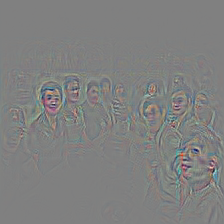

In [53]:
--print(deconvNet_test)

deconv_timer2 = torch.Timer()
vis_c5_test = deconvNet_test:forward(net:get(1):get(13).output)

print('==> Time elapsed: ' .. deconv_timer2:time().real .. ' seconds')
itorch.image(vis_c5_test )


inn.SpatialSameResponseNormalization This type of layer is not supported !	


inn.SpatialSameResponseNormalization This type of layer is not supported !	


==> Time elapsed: 0.24328994750977 seconds	


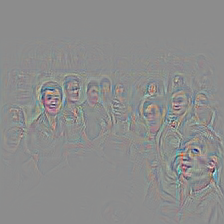

In [68]:
deconvNet_test2 = dcnn:CreateDeconvNet( net:get(1), unpooling_layers, I, 13, 27 )
deconv_timer3 = torch.Timer()
vis_c5_test2 = deconvNet_test2:forward(net:get(1):get(13).output)

print('==> Time elapsed: ' .. deconv_timer3:time().real .. ' seconds')
itorch.image(vis_c5_test2 )


In [22]:
deconvNet

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> output]
  (1): cudnn.SpatialDeconvolution(256 -> 384, 3x3, 1,1, 1,1)
  (2): cudnn.ReLU
  (3): cudnn.SpatialDeconvolution(384 -> 384, 3x3, 1,1, 1,1)
  (4): cudnn.ReLU
  (5): cudnn.SpatialDeconvolution(384 -> 256, 3x3, 1,1, 1,1)
  (6): dcnn.DualSpatialMaxUnpooling
  (7): cudnn.ReLU
  (8): cudnn.SpatialDeconvolution(256 -> 96, 5x5, 2,2)
  (9): dcnn.DualSpatialMaxUnpooling
  (10): cudnn.ReLU
  (11): cudnn.SpatialDeconvolution(96 -> 3, 7x7, 2,2, 1,1)
}
{
  gradInput : DoubleTensor - empty
  modules : 
    {
      1 : 
        cudnn.SpatialDeconvolution(256 -> 384, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 256
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 27


          iSize : LongStorage - size: 4
          normal_deconv : false
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 384
          padH : 1
          kH : 3
          weight : CudaTensor - size: 256x384x3x3
          gradWeight : CudaTensor - size: 256x384x3x3
          kW : 3
          reconstruction_size : 13
          bias : DoubleTensor - size: 384
          gradBias : DoubleTensor - size: 384
        }
      2 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 384x13x13
          gradInput : DoubleTensor - empty
          nElem : 64896
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41608e10
        }
      3 : 
        cudnn.SpatialDeconvolution(384 -> 384, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 384
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 0
         

 iSize : LongStorage - size: 4
          normal_deconv : true
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 384
          padH : 1
          kH : 3
          weight : CudaTensor - size: 384x384x3x3
          gradWeight : CudaTensor - size: 384x384x3x3
          kW : 3
          reconstruction_size : 13
          bias : DoubleTensor - size: 384
          gradBias : DoubleTensor - size: 384
        }
      4 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 384x13x13
          gradInput : DoubleTensor - empty
          nElem : 64896
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x410a9188
        }
      5 : 
        cudnn.SpatialDeconvolution(384 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 384
          output : DoubleTensor - empty
     

     gradInput : DoubleTensor - empty
          neuron_num : 0
          iSize : LongStorage - size: 4
          normal_deconv : true
          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 256
          padH : 1
          kH : 3
          weight : CudaTensor - size: 384x256x3x3
          gradWeight : CudaTensor - size: 384x256x3x3
          kW : 3
          reconstruction_size : 13
          bias : DoubleTensor - size: 256
          gradBias : DoubleTensor - size: 256
        }
      6 : 
        dcnn.DualSpatialMaxUnpooling
        {
          gradInput : CudaTensor - empty
          dualModule : 
            dcnn.DualSpatialMaxPooling(3,3,2,2)
            {
              dH : 2
              dW : 2
              padH : 0
              gradInput : CudaTensor - empty
              indices : CudaTensor - size: 256x13x13
              dualModule : 
             

   dcnn.DualSpatialMaxUnpooling
                {
                  gradInput : CudaTensor - empty
                  dualModule : dcnn.DualSpatialMaxPooling(3,3,2,2)
                  output : CudaTensor - size: 256x26x26
                }
              kH : 3
              output : CudaTensor - size: 256x13x13
              padW : 0
              kW : 3
            }
          output : CudaTensor - size: 256x26x26
        }
      7 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 256x26x26
          gradInput : DoubleTensor - empty
          nElem : 173056
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41bb9978
        }
      8 : 
        cudnn.SpatialDeconvolution(256 -> 96, 5x5, 2,2)
        {
          padW : 0
          nInputPlane : 256
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 0


          iSize : LongStorage - size: 4
          normal_deconv : true
          groups : 1
          dH : 2
          dW : 2
          nOutputPlane : 96
          padH : 0
          kH : 5
          weight : CudaTensor - size: 256x96x5x5
          gradWeight : CudaTensor - size: 256x96x5x5
          kW : 5
          reconstruction_size : 55
          bias : DoubleTensor - size: 96
          gradBias : DoubleTensor - size: 96
        }
      9 : 
        dcnn.DualSpatialMaxUnpooling
        {
          gradInput : CudaTensor - empty
          dualModule : 
            dcnn.DualSpatialMaxPooling(3,3,2,2)
            {
              dH : 2
              dW : 2
              padH : 0
              gradInput : CudaTensor - empty
              indices : CudaTensor - size: 96x55x55
              dualModule : 
                dcnn.DualSpatialMaxUnpooling
                {


                  gradInput : CudaTensor - empty
                  dualModule : dcnn.DualSpatialMaxPooling(3,3,2,2)
                  output : CudaTensor - size: 96x110x110
                }
              kH : 3
              output : CudaTensor - size: 96x55x55
              padW : 0
              kW : 3
            }
          output : CudaTensor - size: 96x110x110
        }
      10 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 96x110x110
          gradInput : DoubleTensor - empty
          nElem : 1161600
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x40b34238
        }
      11 : 
        cudnn.SpatialDeconvolution(96 -> 3, 7x7, 2,2, 1,1)
        {
          padW : 1
          nInputPlane : 96
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 0
          iSize : LongStorage - size: 4
         

 normal_deconv : true
          groups : 1
          dH : 2
          dW : 2
          nOutputPlane : 3
          padH : 1
          kH : 7
          weight : CudaTensor - size: 96x3x7x7
          gradWeight : CudaTensor - size: 96x3x7x7
          kW : 7
          reconstruction_size : 224
          bias : DoubleTensor - size: 3
          gradBias : DoubleTensor - size: 3
        }
    }
  output : CudaTensor - size: 3x224x224
}


In [13]:
deconvNet_test

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> output]
  (1): cudnn.SpatialDeconvolution(256 -> 384, 3x3, 1,1, 1,1)
  (2): cudnn.ReLU
  (3): cudnn.SpatialDeconvolution(384 -> 384, 3x3, 1,1, 1,1)
  (4): cudnn.ReLU
  (5): cudnn.SpatialDeconvolution(384 -> 256, 3x3, 1,1, 1,1)
  (6): dcnn.DualSpatialMaxUnpooling
  (7): cudnn.ReLU
  (8): cudnn.SpatialDeconvolution(256 -> 96, 5x5, 2,2)
  (9): dcnn.DualSpatialMaxUnpooling
  (10): cudnn.ReLU
  (11): cudnn.SpatialDeconvolution(96 -> 3, 7x7, 2,2, 1,1)
}
{
  gradInput : DoubleTensor - empty
  modules : 
    {
      1 : 
        cudnn.SpatialDeconvolution(256 -> 384, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 256
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 27
          iSize : LongStorage - size: 4
          normal_deconv : false
          groups : 1
          dH : 1
          dW : 1
          nOutputPl

          weight : CudaTensor - size: 256x384x3x3
          gradWeight : CudaTensor - size: 256x384x3x3
          kW : 3
          reconstruction_size : 13
          bias : DoubleTensor - size: 384
          gradBias : DoubleTensor - size: 384
        }
      2 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 384x13x13
          gradInput : DoubleTensor - empty
          nElem : 64896
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x407f2e48
        }
      3 : 
        cudnn.SpatialDeconvolution(384 -> 384, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 384
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 0
          iSize : LongStorage - size: 4
          normal_deconv : true
          groups : 1
          dH : 1
          dW : 1
         

 nOutputPlane : 384
          padH : 1
          kH : 3
          weight : CudaTensor - size: 384x384x3x3
          gradWeight : CudaTensor - size: 384x384x3x3
          kW : 3
          reconstruction_size : 13
          bias : DoubleTensor - size: 384
          gradBias : DoubleTensor - size: 384
        }
      4 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 384x13x13
          gradInput : DoubleTensor - empty
          nElem : 64896
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x41103a78
        }
      5 : 
        cudnn.SpatialDeconvolution(384 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 384
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 0
          iSize : LongStorage - size: 4
          normal_deconv : true


          groups : 1
          dH : 1
          dW : 1
          nOutputPlane : 256
          padH : 1
          kH : 3
          weight : CudaTensor - size: 384x256x3x3
          gradWeight : CudaTensor - size: 384x256x3x3
          kW : 3
          reconstruction_size : 13
          bias : DoubleTensor - size: 256
          gradBias : DoubleTensor - size: 256
        }
      6 : 
        dcnn.DualSpatialMaxUnpooling
        {
          gradInput : CudaTensor - empty
          dualModule : 
            dcnn.DualSpatialMaxPooling(3,3,2,2)
            {
              dH : 2
              dW : 2
              padH : 0
              gradInput : CudaTensor - empty
              indices : CudaTensor - size: 256x13x13
              dualModule : 
                dcnn.DualSpatialMaxUnpooling


                {
                  gradInput : CudaTensor - empty
                  dualModule : dcnn.DualSpatialMaxPooling(3,3,2,2)
                  output : CudaTensor - size: 256x26x26
                }
              kH : 3
              output : CudaTensor - size: 256x13x13
              padW : 0
              kW : 3
            }
          output : CudaTensor - size: 256x26x26
        }
      7 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 256x26x26
          gradInput : DoubleTensor - empty
          nElem : 173056
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x418d9398
        }
      8 : 
        cudnn.SpatialDeconvolution(256 -> 96, 5x5, 2,2)
        {
          padW : 0
          nInputPlane : 256
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty


          neuron_num : 0
          iSize : LongStorage - size: 4
          normal_deconv : true
          groups : 1
          dH : 2
          dW : 2
          nOutputPlane : 96
          padH : 0
          kH : 5
          weight : CudaTensor - size: 256x96x5x5
          gradWeight : CudaTensor - size: 256x96x5x5
          kW : 5
          reconstruction_size : 55
          bias : DoubleTensor - size: 96
          gradBias : DoubleTensor - size: 96
        }
      9 : 
        dcnn.DualSpatialMaxUnpooling
        {
          gradInput : CudaTensor - empty
          dualModule : 
            dcnn.DualSpatialMaxPooling(3,3,2,2)
            {
              dH : 2
              dW : 2
              padH : 0
              gradInput : CudaTensor - empty
              indices : CudaTensor - size: 96x55x55
              dualModule : 
                dcnn.DualSpatialMaxUnpooling
                {
                  gradInput : CudaTensor - empty
                  dualModule : dcnn.DualSpatialM

                  output : CudaTensor - size: 96x110x110
                }
              kH : 3
              output : CudaTensor - size: 96x55x55
              padW : 0
              kW : 3
            }
          output : CudaTensor - size: 96x110x110
        }
      10 : 
        cudnn.ReLU
        {
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          output : CudaTensor - size: 96x110x110
          gradInput : DoubleTensor - empty
          nElem : 1161600
          iDesc : cdata<struct cudnnTensorStruct *[1]>: 0x4087bfe0
        }
      11 : 
        cudnn.SpatialDeconvolution(96 -> 3, 7x7, 2,2, 1,1)
        {
          padW : 1
          nInputPlane : 96
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          neuron_num : 0
          iSize : LongStorage - size: 4
          normal_deconv : true
          groups : 1
          dH : 2
          dW : 2
          nOutputPlane : 3
          padH : 1
          kH : 7


          weight : CudaTensor - size: 96x3x7x7
          gradWeight : CudaTensor - size: 96x3x7x7
          kW : 7
          reconstruction_size : 224
          bias : DoubleTensor - size: 3
          gradBias : DoubleTensor - size: 3
        }
    }
  output : CudaTensor - size: 3x224x224
}
